# Content-Based Recommendation System

Create a content-based recommendation system using cosine similarity on feature matrices.

In [245]:
# Standard data science libraries
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# Other libraries
import time
import pickle
import re
from PIL import Image
# sklearn packages
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [201]:
with open('df_w_features.pickle', 'rb') as f:
    df= pickle.load(f)

In [203]:
df.reset_index(inplace=True, drop=True)

In [204]:
df = df.drop(columns='index')

In [205]:
df.head()

,name,brand,price,bag_url,img_filename,label,is_ethical,source,cleaned_price,feature_matrix
0,Tote,Victoria's Secret,$21.99$74,https://www.thredup.com/product/handbags-victo...,thredup_vic_0.png,totes,1,thredup,21.99,"[[0.0, 34.082092, 120.07053, 34.426167, 60.972..."
1,Tote,Anne Klein,$17.99$69,https://www.thredup.com/product/handbags-anne-...,thredup_ann_1.png,totes,1,thredup,17.99,"[[0.0, 59.236874, 93.56827, 3.9990442, 0.0, 25..."
2,Tote,Unbranded,$16.99$60,https://www.thredup.com/product/handbags-unbra...,thredup_unb_2.png,totes,1,thredup,16.99,"[[0.0, 62.95456, 4.9559455, 45.43826, 0.0, 143..."
3,Tote,Unbranded,$15.99$60,https://www.thredup.com/product/handbags-unbra...,thredup_unb_3.png,totes,1,thredup,15.99,"[[0.0, 32.848614, 31.133387, 28.699326, 4.2855..."
4,Tote,Victoria's Secret,$25.99$68,https://www.thredup.com/product/handbags-victo...,thredup_vic_4.png,totes,1,thredup,25.99,"[[0.0, 55.67337, 91.1055, 17.396587, 8.476363,..."


#### Create master feature matrix

In [229]:
feature_matrix = np.reshape(np.matrix(df['feature_matrix']), (-1,1))

In [230]:
df_feature_matrix = pd.DataFrame(df['feature_matrix'])

In [231]:
df_feature_matrix.head()

,feature_matrix
0,"[[0.0, 34.082092, 120.07053, 34.426167, 60.972..."
1,"[[0.0, 59.236874, 93.56827, 3.9990442, 0.0, 25..."
2,"[[0.0, 62.95456, 4.9559455, 45.43826, 0.0, 143..."
3,"[[0.0, 32.848614, 31.133387, 28.699326, 4.2855..."
4,"[[0.0, 55.67337, 91.1055, 17.396587, 8.476363,..."


In [232]:
# df_feature_matrix.rename({0: 'feature_matrix'}, axis=1, inplace=True)

In [233]:
def matrix_to_array(row):
    return np.array(row.feature_matrix[0])

In [234]:
df_feature_matrix.columns

Index(['feature_matrix'], dtype='object')

In [235]:
df_feature_matrix['feature_list'] = df_feature_matrix.apply(matrix_to_array, axis=1)

In [236]:
df_feature_matrix.head()

,feature_matrix,feature_list
0,"[[0.0, 34.082092, 120.07053, 34.426167, 60.972...","[0.0, 34.082092, 120.07053, 34.426167, 60.9722..."
1,"[[0.0, 59.236874, 93.56827, 3.9990442, 0.0, 25...","[0.0, 59.236874, 93.56827, 3.9990442, 0.0, 25...."
2,"[[0.0, 62.95456, 4.9559455, 45.43826, 0.0, 143...","[0.0, 62.95456, 4.9559455, 45.43826, 0.0, 143...."
3,"[[0.0, 32.848614, 31.133387, 28.699326, 4.2855...","[0.0, 32.848614, 31.133387, 28.699326, 4.28552..."
4,"[[0.0, 55.67337, 91.1055, 17.396587, 8.476363,...","[0.0, 55.67337, 91.1055, 17.396587, 8.476363, ..."


In [237]:
# create a master matrix containing all feature matrices
feature_matrix = np.zeros((6094,1024))

for i, row in df_feature_matrix.iterrows():
    for idx, num in enumerate(row['feature_list']):
        feature_matrix[i][idx] += num

In [238]:
feature_matrix.shape

(6094, 1024)

In [246]:
# create the cosine similarity matrices
lin_kernel = linear_kernel(feature_matrix, feature_matrix)
cosine_sim = cosine_similarity(feature_matrix, feature_matrix)

# construct a reverse map of filenames and movie titles
indices = pd.Series(df.index, index=df['img_filename']).drop_duplicates()

In [247]:
def display_recommendations(filename, similarity_matrix):
    # Get filepath of input image
    input_label = re.findall('(totes|backpacks|shoulder_bags|clutches|fanny_packs|weekenders|bucket_bags|circles)' ,str(df[df['img_filename']==filename]['label']))[0]
    input_filepath = f'./data_original/{input_label}/{filename}'
    
    # Get the index of the bag that matches the filename
    idx = indices[filename]

    # Get the pairwise similarity scores of all bags with that bag
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # Sort the filenames based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar bags
    sim_scores = sim_scores[0:6]

    # Get the bag indices
    img_indices = [i[0] for i in sim_scores]

    # Get the top 10 most similar bag filenames
    top_results = df['img_filename'].iloc[img_indices]
    
    # Display images
    print('INPUT IMAGE:')
    print('------------')
    print(filename)
    input_image = Image.open(input_filepath)
    display(input_image.resize((250, 250), Image.ANTIALIAS))
    print('MOST SIMILAR IMAGES:')
    print('--------------------')
    for i, result in enumerate(list(top_results)):
        print(result)
        print(sim_scores[i])
        output_label = re.findall('(totes|backpacks|shoulder_bags|clutches|fanny_packs|weekenders|bucket_bags|circles)' ,str(df[df['img_filename']==result]['label']))[0]
        output_image = Image.open(f'./data_original/{output_label}/{result}')
        display(output_image.resize((250, 250), Image.ANTIALIAS))

INPUT IMAGE:
------------
thredup_bra_13.png


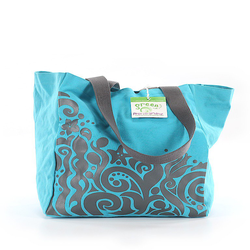

MOST SIMILAR IMAGES:
--------------------
thredup_bra_13.png
(13, 1.0000000000000013)


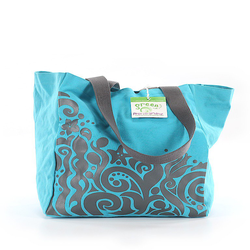

thredup_bra_6.png
(6, 0.833880609870583)


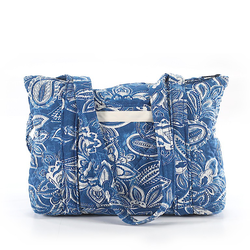

thredup_unb_398.png
(398, 0.8223965001842832)


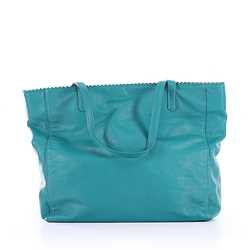

thredup_unb_401.png
(405, 0.8191092373186278)


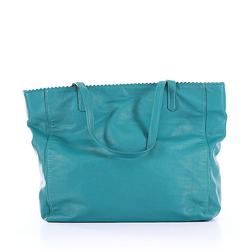

thredup_don_489.png
(493, 0.806316192631173)


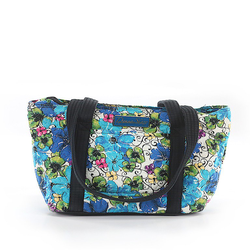

thredup_mud_541.png
(545, 0.8055089763326965)


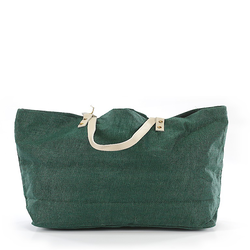

In [249]:
display_recommendations('thredup_bra_13.png', cosine_sim)

INPUT IMAGE:
------------
thredup_bra_13.png


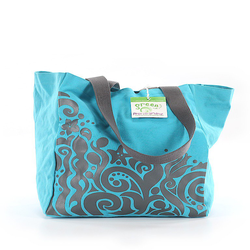

MOST SIMILAR IMAGES:
--------------------
thredup_vic_14.png
(14, 1198739.365854008)


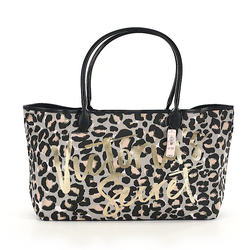

omybag__51.png
(5965, 1182727.896059358)


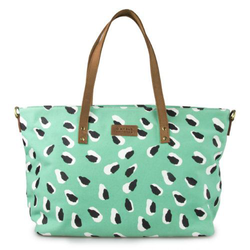

th_1.jpg
(2936, 1105771.5355621662)


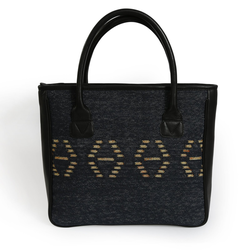

thredup_unb_688.png
(692, 1038701.3941163186)


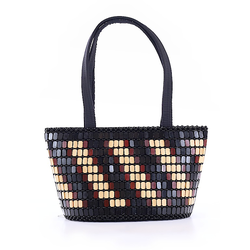

thredup_unb_79.png
(79, 1036854.0966539036)


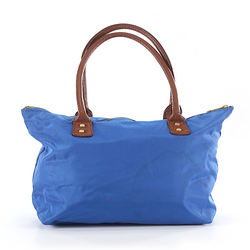

th_2.jpg
(2937, 988922.7654887727)


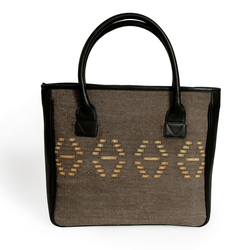

In [248]:
display_recommendations('thredup_bra_13.png', lin_kernel)

INPUT IMAGE:
------------
nordstrom_54.png


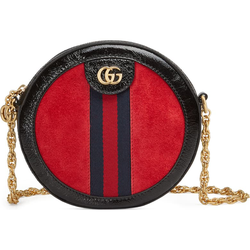

MOST SIMILAR IMAGES:
--------------------
nordstrom_54.png
(5895, 1.0000000000000007)


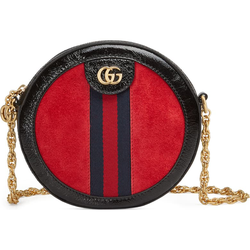

nordstrom_67.png
(5908, 0.8219909479212212)


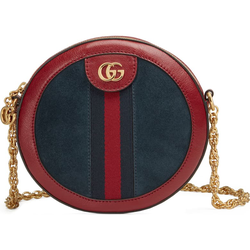

nordstrom_55.png
(5896, 0.8153987797901321)


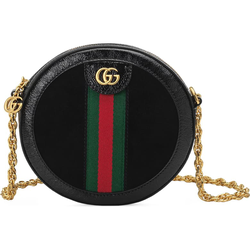

thredup_unb_285.png
(285, 0.7761623064883139)


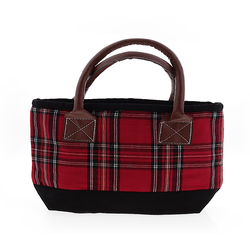

za_301.jpg
(3748, 0.7723407557900002)


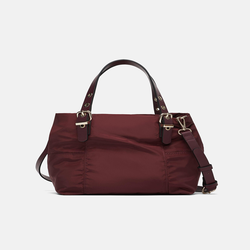

thredup_bra_1990.png
(1467, 0.7701038487148288)


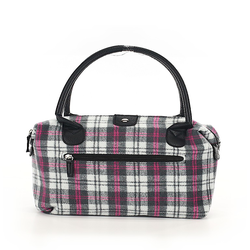

In [251]:
display_recommendations('nordstrom_54.png', cosine_sim)

INPUT IMAGE:
------------
nordstrom_54.png


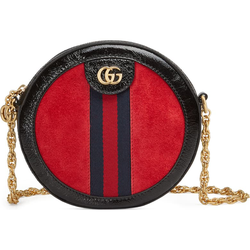

MOST SIMILAR IMAGES:
--------------------
nordstrom_60.png
(5901, 1586676.4569057042)


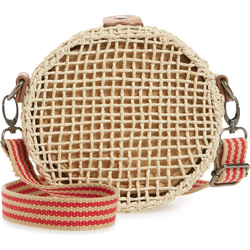

thredup_unb_285.png
(285, 1543448.0852267018)


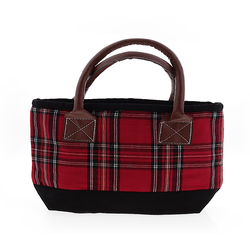

nordstrom_55.png
(5896, 1505308.4409116192)


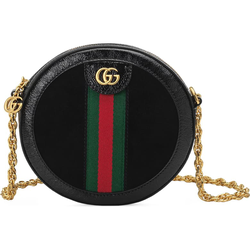

nordstrom_33.png
(5874, 1496855.7463129165)


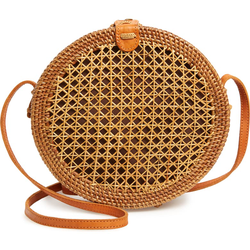

nordstrom_67.png
(5908, 1494740.7444585005)


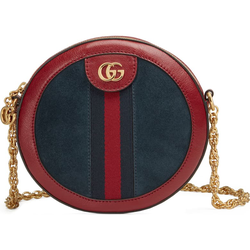

thredup_ann_2274.png
(1749, 1494587.0939248314)


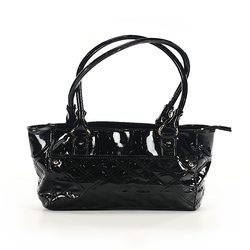

In [250]:
display_recommendations('nordstrom_54.png', lin_kernel)

INPUT IMAGE:
------------
za_257.jpg


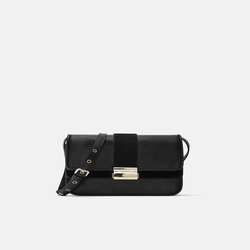

MOST SIMILAR IMAGES:
--------------------
za_257.jpg
(3704, 1.0000000000000002)


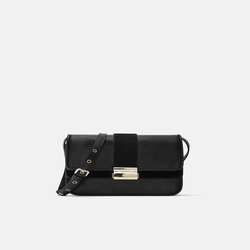

za_195.jpg
(3647, 0.9340332840720595)


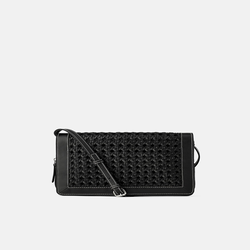

top_200.png
(3349, 0.9314804673705128)


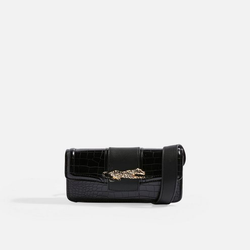

za_68.jpg
(3520, 0.9312099938748425)


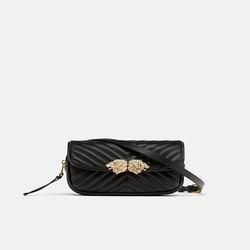

thredup_jud_1507.png
(1399, 0.9301847332708325)


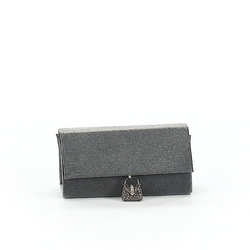

za_272.jpg
(3719, 0.9267611851401252)


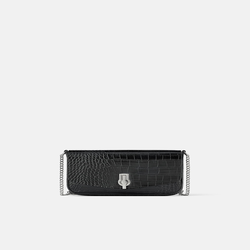

In [252]:
display_recommendations('za_257.jpg', cosine_sim)

INPUT IMAGE:
------------
za_257.jpg


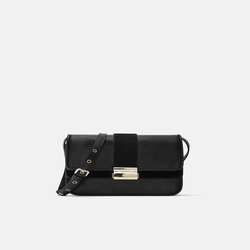

MOST SIMILAR IMAGES:
--------------------
herschel_202.png
(3977, 564419.8750436279)


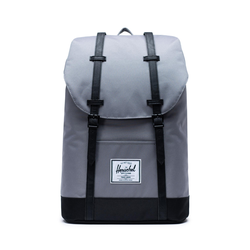

herschel_360.png
(4135, 536680.4852249192)


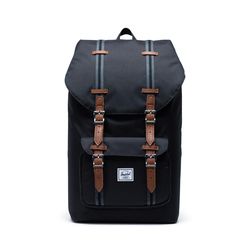

thredup_ann_2274.png
(1749, 532918.6627380425)


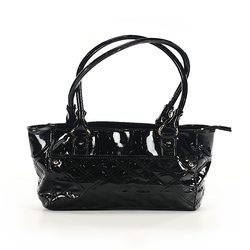

herschel_203.png
(3978, 531300.3066538229)


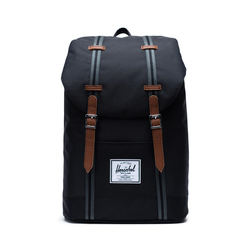

herschel_192.png
(3967, 528690.5837463599)


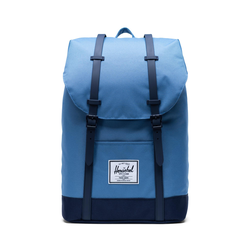

herschel_201.png
(3976, 524314.921432783)


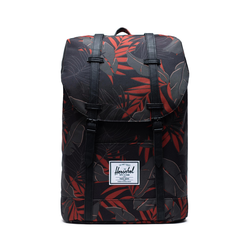

In [243]:
display_recommendations('za_257.jpg', lin_kernel)

INPUT IMAGE:
------------
ia_48.png


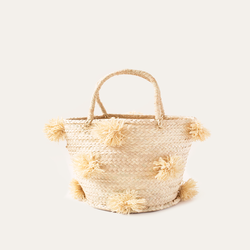

MOST SIMILAR IMAGES:
--------------------
ia_48.png
(2408, 1.0000000000000009)


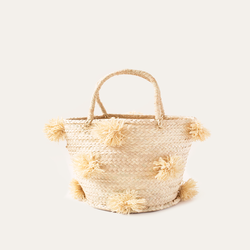

ia_39.png
(2399, 0.8960223128300149)


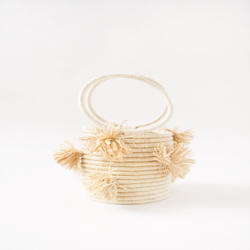

ia_33.png
(2393, 0.8771353304210316)


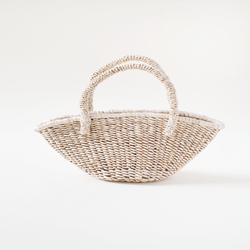

ia_38.png
(2398, 0.8721113770782318)


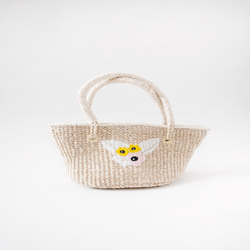

thredup_men_1138.png
(966, 0.8609770820781928)


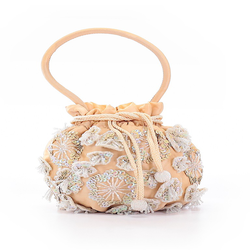

av_35.png
(2625, 0.8462882591496399)


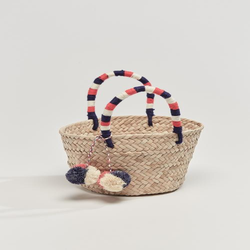

In [253]:
display_recommendations('ia_48.png', cosine_sim)

INPUT IMAGE:
------------
th_21.jpg


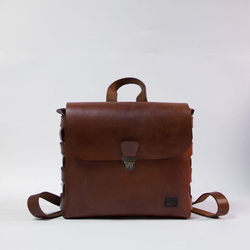

MOST SIMILAR IMAGES:
--------------------
th_21.jpg
(2956, 1.0000000000000009)


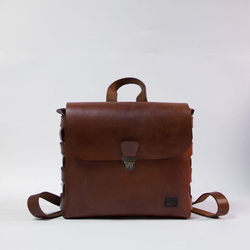

th_55.jpg
(2990, 0.8702206629010525)


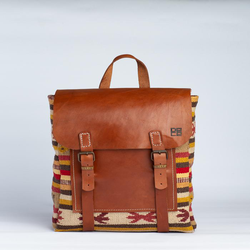

herschel_1348.png
(5123, 0.8680603190299285)


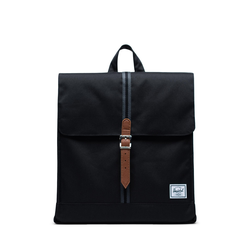

za_181.jpg
(3633, 0.8670061260083292)


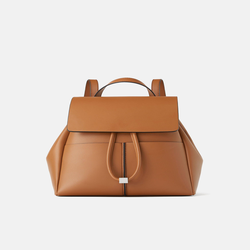

herschel_162.png
(3937, 0.8641954489495731)


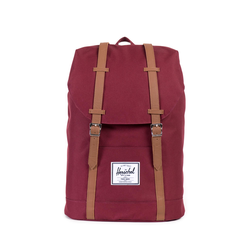

herschel_1346.png
(5121, 0.8611151145244845)


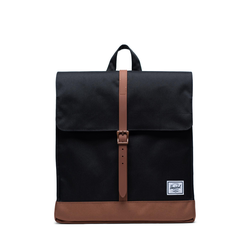

In [256]:
display_recommendations('th_21.jpg', cosine_sim)